<a href="https://colab.research.google.com/github/TimH2024/MSC-M5-Project/blob/main/3_Correlation%2C_feature_selection_and_completeness%2C_skewness_and_anomalies_in_the_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3. Data completeness, skewness and anomalies

---

#### Load Libraries

In [ ]:

!pip install tensorflow
!pip install scikeras
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import uniform, randint
import warnings

# Suppress user warnings
warnings.filterwarnings('ignore')

# Adjust settings to display all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns


In [ ]:
# Get the files from GitHub raw URLs for the datasets
# dataset_url = 'https://raw.githubusercontent.com/TimH2024/MSC-M5-Project/main/Datasetv2.csv'
# property_dataset_url = 'https://raw.githubusercontent.com/TimH2024/MSC-M5-Project/main/Property_data_raw_2.csv'

# Read in the data sets
# dataset = pd.read_csv(dataset_url)
# property_dataset = pd.read_csv(property_dataset_url)

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path
file_path = '/content/drive/My Drive/Colab Notebooks/M5 Code and Data/Merged_Datasetv3.csv'

# Load the CSV file into a pandas DataFrame called "merged_dataset"
merged_dataset = pd.read_csv(file_path)

# Display information about the DataFrame
print("\nDataset Info:")
merged_dataset.info()  # Information about columns, data types, and memory usage

# Display the shape of the DataFrame
print("\nDataset Shape:")
print(f"Rows: {merged_dataset.shape[0]}, Columns: {merged_dataset.shape[1]}")

Mounted at /content/drive

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109851 entries, 0 to 109850
Data columns (total 67 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   saleable_area(ft^2)                             109851 non-null  int64  
 1   unit_rate                                       109851 non-null  int64  
 2   district                                        109851 non-null  object 
 3   floor                                           109851 non-null  float64
 4   FormattedDate                                   109851 non-null  object 
 5   YearQuarter                                     109851 non-null  object 
 6   CG                                              109851 non-null  float64
 7   CI                                              109851 non-null  float64
 8   CPI                                             109851 non-null

In [ ]:
# Convert 'FormattedDate' to datetime using dayfirst and handling errors
merged_dataset['FormattedDate'] = pd.to_datetime(merged_dataset['FormattedDate'], dayfirst=True, errors='coerce')

# Verify the conversion and check for invalid/missing dates
print(merged_dataset['FormattedDate'].head())

# Identify rows with invalid dates
invalid_dates = merged_dataset[merged_dataset['FormattedDate'].isna()]
print("Invalid dates found:\n", invalid_dates)

0   2023-03-08
1   2023-03-08
2   2023-03-08
3   2023-03-08
4   2023-03-08
Name: FormattedDate, dtype: datetime64[ns]
Invalid dates found:
 Empty DataFrame
Columns: [saleable_area(ft^2), unit_rate, district, floor, FormattedDate, YearQuarter, CG, CI, CPI, GDP, HS, IR, LTV, M3, MW, PG, PI, SD, SM, SOLD, UR, region, district_Central and Western District, district_HKIsIand Eastern District, district_HKIsIand Southern District, district_Kowloon Kowloon City District, district_Kowloon Kwun Tong District, district_Kowloon Sham Shui Po District, district_Kowloon Wong Tai Sin District, district_Kowloon Yau Tsim Mong District, district_Kwai Tsing District, district_New Territories East Long Ping Estate, district_New Territories East North District, district_New Territories East Sha Tin District, district_New Territories East Tai Po District, district_New Territories West Islands District, district_Tsuen Wan District, district_Tuen Mun District, district_Wan Chai District, district_Yuen Long Dis

In [ ]:
import pandas as pd

# Assuming `merged_dataset` is already loaded as a pandas DataFrame
# Convert 'FormattedDate' column to datetime
merged_dataset['FormattedDate'] = pd.to_datetime(merged_dataset['FormattedDate'])

# Extract timestamp (in seconds since epoch)
merged_dataset['Timestamp'] = merged_dataset['FormattedDate'].apply(lambda x: x.timestamp())

# At this stage, DO NOT scale the timestamp
# Save the dataset as-is for later use
print(merged_dataset[['FormattedDate', 'Timestamp']].head())

  FormattedDate     Timestamp
0    2023-03-08  1.678234e+09
1    2023-03-08  1.678234e+09
2    2023-03-08  1.678234e+09
3    2023-03-08  1.678234e+09
4    2023-03-08  1.678234e+09


In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109851 entries, 0 to 109850
Data columns (total 68 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   saleable_area(ft^2)                             109851 non-null  int64         
 1   unit_rate                                       109851 non-null  int64         
 2   district                                        109851 non-null  object        
 3   floor                                           109851 non-null  float64       
 4   FormattedDate                                   109851 non-null  datetime64[ns]
 5   YearQuarter                                     109851 non-null  object        
 6   CG                                              109851 non-null  float64       
 7   CI                                              109851 non-null  float64       
 8   CPI                               

# FEATURE SELECTION

In [ ]:
# Mutual Selection method

# Step 1: Define X and y from the loaded dataset
X = merged_dataset.drop(columns=['new_price', 'PI'], errors='ignore')  # Exclude target columns from features
y_new_price = merged_dataset['new_price']  # Target variable 1
y_PI = merged_dataset['PI']  # Target variable 2

# Step 2: Randomly sample 20,000 rows
sampled_data = X.sample(n=20000, random_state=42)  # Random sample of 20,000 rows
sampled_targets_new_price = y_new_price.loc[sampled_data.index]  # Match sampled rows for 'new_price'
sampled_targets_PI = y_PI.loc[sampled_data.index]  # Match sampled rows for 'PI'

# Step 3: Identify categorical columns
categorical_columns = sampled_data.select_dtypes(include=['object']).columns

# Step 4: Use Label Encoding for categorical columns
sampled_data_encoded = sampled_data.copy()
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    sampled_data_encoded[col] = le.fit_transform(sampled_data[col].astype(str))
    label_encoders[col] = le

# Step 5: Exclude obvious or redundant features and multicollerinity
features_to_exclude = [col for col in sampled_data_encoded.columns if col.startswith(("property_size_","district_", "YearQuarter_", "region_"))] + ['new_price_million', 'property_size','YearQuarter','FormattedDate', 'unit_rate', 'price_per_sqft', 'Timestamp']
sampled_data_filtered = sampled_data_encoded.drop(columns=features_to_exclude, errors='ignore')

# Step 6: Compute Mutual Information
mi_new_price = mutual_info_regression(sampled_data_filtered, sampled_targets_new_price)
mi_PI = mutual_info_regression(sampled_data_filtered, sampled_targets_PI)

# Step 7: Create DataFrames for results
mi_new_price_df = pd.DataFrame({'Feature': sampled_data_filtered.columns, 'Mutual Information': mi_new_price})
mi_PI_df = pd.DataFrame({'Feature': sampled_data_filtered.columns, 'Mutual Information': mi_PI})

# Add a column to indicate the target variable
mi_new_price_df['Target'] = 'new_price'
mi_PI_df['Target'] = 'PI'

# Concatenate the two DataFrames
master_df = pd.concat([mi_new_price_df, mi_PI_df], ignore_index=True)

# Sort the master DataFrame by mutual information in descending order
master_df = master_df.sort_values(by='Mutual Information', ascending=False)

# Print the top 10 features for each target
print("Top 10 features for new_price based on Mutual Information:")
print(mi_new_price_df.head(10).to_string(index=False))  # Print without the index

print("\nTop 10 features for PI based on Mutual Information:")
print(mi_PI_df.head(10).to_string(index=False))  # Print without the index

# Save the master DataFrame to a single CSV file, overwriting it each time
master_df.to_csv('master_selection.csv', index=False)

print("\nMutual Information results saved to 'master_selection.csv'.")

Top 10 features for new_price based on Mutual Information:
            Feature  Mutual Information    Target
saleable_area(ft^2)            1.015641 new_price
           district            0.115217 new_price
              floor            0.290885 new_price
                 CG            0.171455 new_price
                 CI            0.168796 new_price
                CPI            0.114716 new_price
                GDP            0.114387 new_price
                 HS            0.110687 new_price
                 IR            0.165674 new_price
                LTV            0.001145 new_price

Top 10 features for PI based on Mutual Information:
            Feature  Mutual Information Target
saleable_area(ft^2)            0.130153     PI
           district            0.528370     PI
              floor            0.009254     PI
                 CG            2.121037     PI
                 CI            2.172683     PI
                CPI            1.162917     PI
         

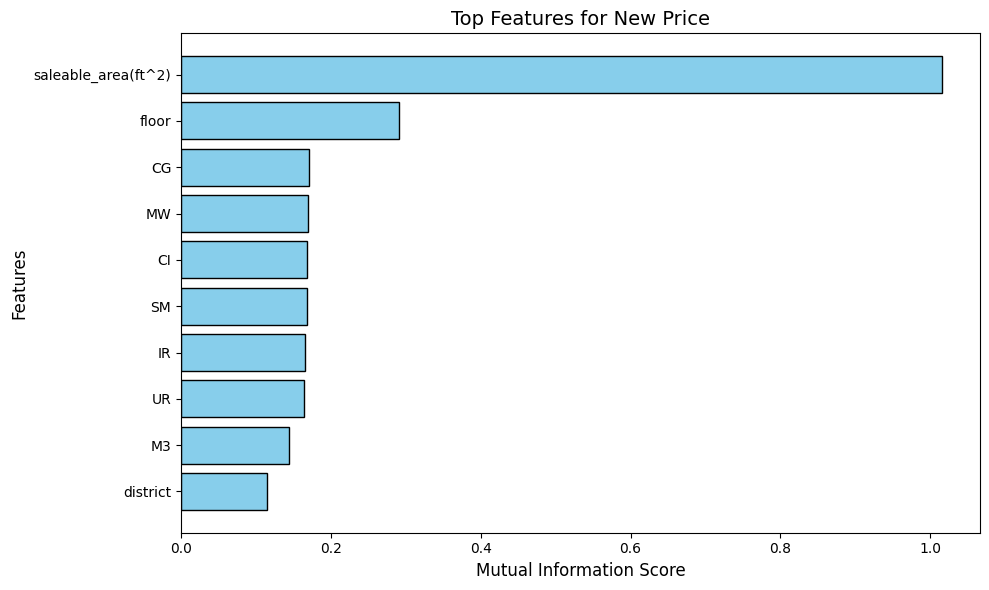

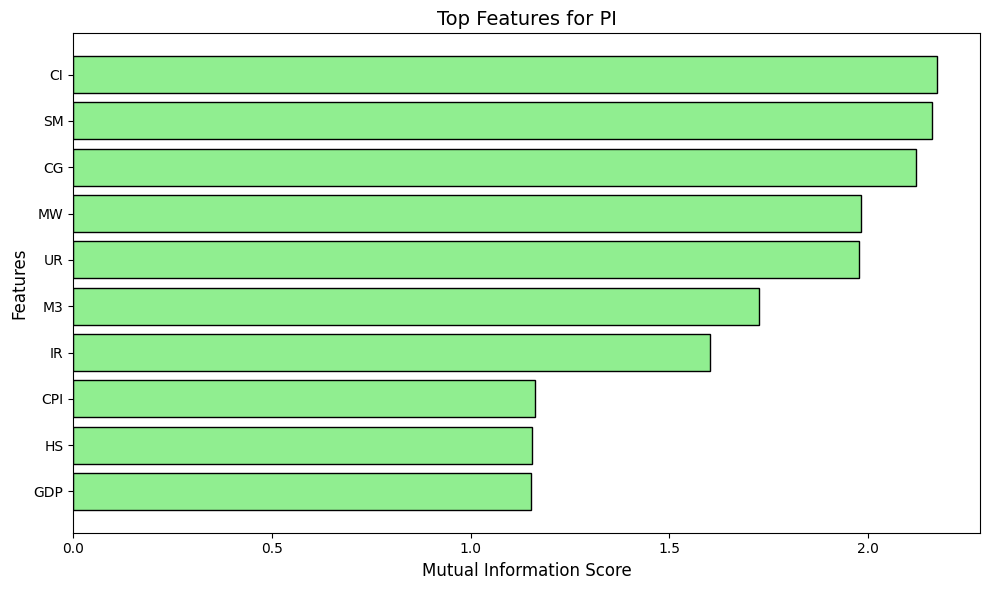

In [ ]:
# Feature graphs

# Step 1: Load the master_selection.csv file
master_df = pd.read_csv("master_selection.csv")

# Step 2: Filter top 10 features for each target
top_features_new_price = (
    master_df[master_df["Target"] == "new_price"]
    .sort_values(by="Mutual Information", ascending=False)
    .head(10)
)
top_features_PI = (
    master_df[master_df["Target"] == "PI"]
    .sort_values(by="Mutual Information", ascending=False)
    .head(10)
)

# Step 3: Plot for `new_price`
plt.figure(figsize=(10, 6))
plt.barh(
    top_features_new_price["Feature"],
    top_features_new_price["Mutual Information"],
    color="skyblue",
    edgecolor="black"
)
plt.xlabel("Mutual Information Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Top Features for New Price", fontsize=14)
plt.gca().invert_yaxis()  # Highest-ranked feature at the top
plt.tight_layout()
plt.show()

# Step 4: Plot for `PI`
plt.figure(figsize=(10, 6))
plt.barh(
    top_features_PI["Feature"],
    top_features_PI["Mutual Information"],
    color="lightgreen",
    edgecolor="black"
)
plt.xlabel("Mutual Information Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Top Features for PI", fontsize=14)
plt.gca().invert_yaxis()  # Highest-ranked feature at the top
plt.tight_layout()
plt.show()

In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109851 entries, 0 to 109850
Data columns (total 68 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   saleable_area(ft^2)                             109851 non-null  int64         
 1   unit_rate                                       109851 non-null  int64         
 2   district                                        109851 non-null  object        
 3   floor                                           109851 non-null  float64       
 4   FormattedDate                                   109851 non-null  datetime64[ns]
 5   YearQuarter                                     109851 non-null  object        
 6   CG                                              109851 non-null  float64       
 7   CI                                              109851 non-null  float64       
 8   CPI                               

# CORRELATION ANALYSYS

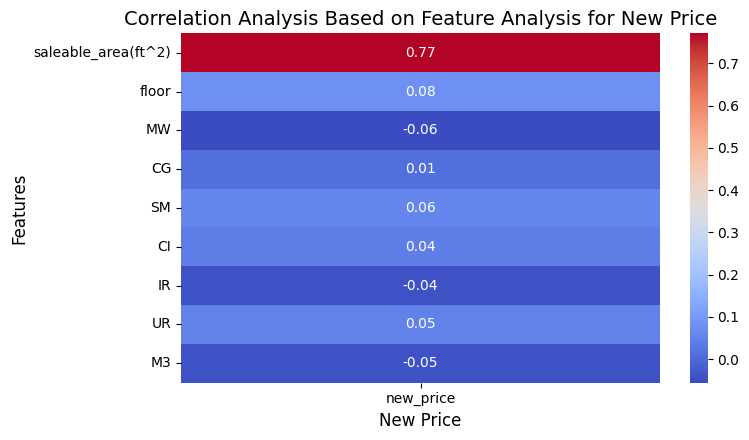

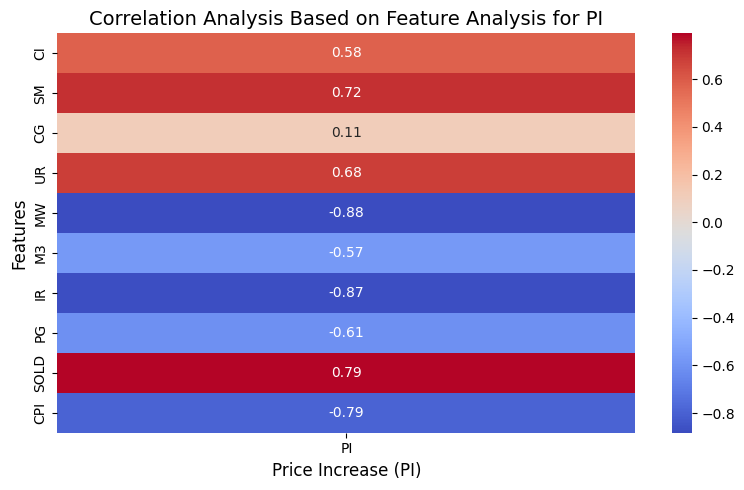

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the dataset (assume `merged_dataset` contains the data)
# merged_dataset = pd.read_csv("merged_dataset.csv")  # Uncomment if needed

# Step 2: Define the features identified in the Mutual Information analysis
new_price_features = [
    'saleable_area(ft^2)', 'floor', 'MW', 'CG', 'SM', 'CI', 'IR', 'UR', 'M3'
]
PI_features = [
    'CI', 'SM', 'CG', 'UR', 'MW', 'M3', 'IR', 'PG', 'SOLD', 'CPI'
]

# Step 3: Ensure the features exist in the dataset
existing_new_price_features = [
    feature for feature in new_price_features if feature in merged_dataset.columns
]
existing_PI_features = [
    feature for feature in PI_features if feature in merged_dataset.columns
]

# Step 4: Compute correlations for `new_price` and `PI`
new_price_corr = merged_dataset[existing_new_price_features + ['new_price']].corr()['new_price'].drop('new_price')
PI_corr = merged_dataset[existing_PI_features + ['PI']].corr()['PI'].drop('PI')

# Step 5: Plot heatmap for `new_price` correlations
plt.figure(figsize=(8, len(new_price_corr) * 0.5))
sns.heatmap(new_price_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Analysis Based on Feature Analysis for New Price', fontsize=14)
plt.xlabel('New Price', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Step 6: Plot heatmap for `PI` correlations
plt.figure(figsize=(8, len(PI_corr) * 0.5))
sns.heatmap(PI_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Analysis Based on Feature Analysis for PI', fontsize=14)
plt.xlabel('Price Increase (PI)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

                                                new_price  \
new_price                                        1.000000   
saleable_area(ft^2)                              0.770753   
district_Central and Western District            0.058937   
district_HKIsIand Eastern District              -0.013347   
district_HKIsIand Southern District              0.112292   
district_Kowloon Kowloon City District           0.009217   
district_Kowloon Kwun Tong District             -0.011994   
district_Kowloon Sham Shui Po District           0.005065   
district_Kowloon Wong Tai Sin District           0.000268   
district_Kowloon Yau Tsim Mong District          0.029345   
district_Kwai Tsing District                    -0.043103   
district_New Territories East Long Ping Estate  -0.017367   
district_New Territories East North District    -0.020320   
district_New Territories East Sha Tin District  -0.008988   
district_New Territories East Tai Po District   -0.019437   
district_New Territories

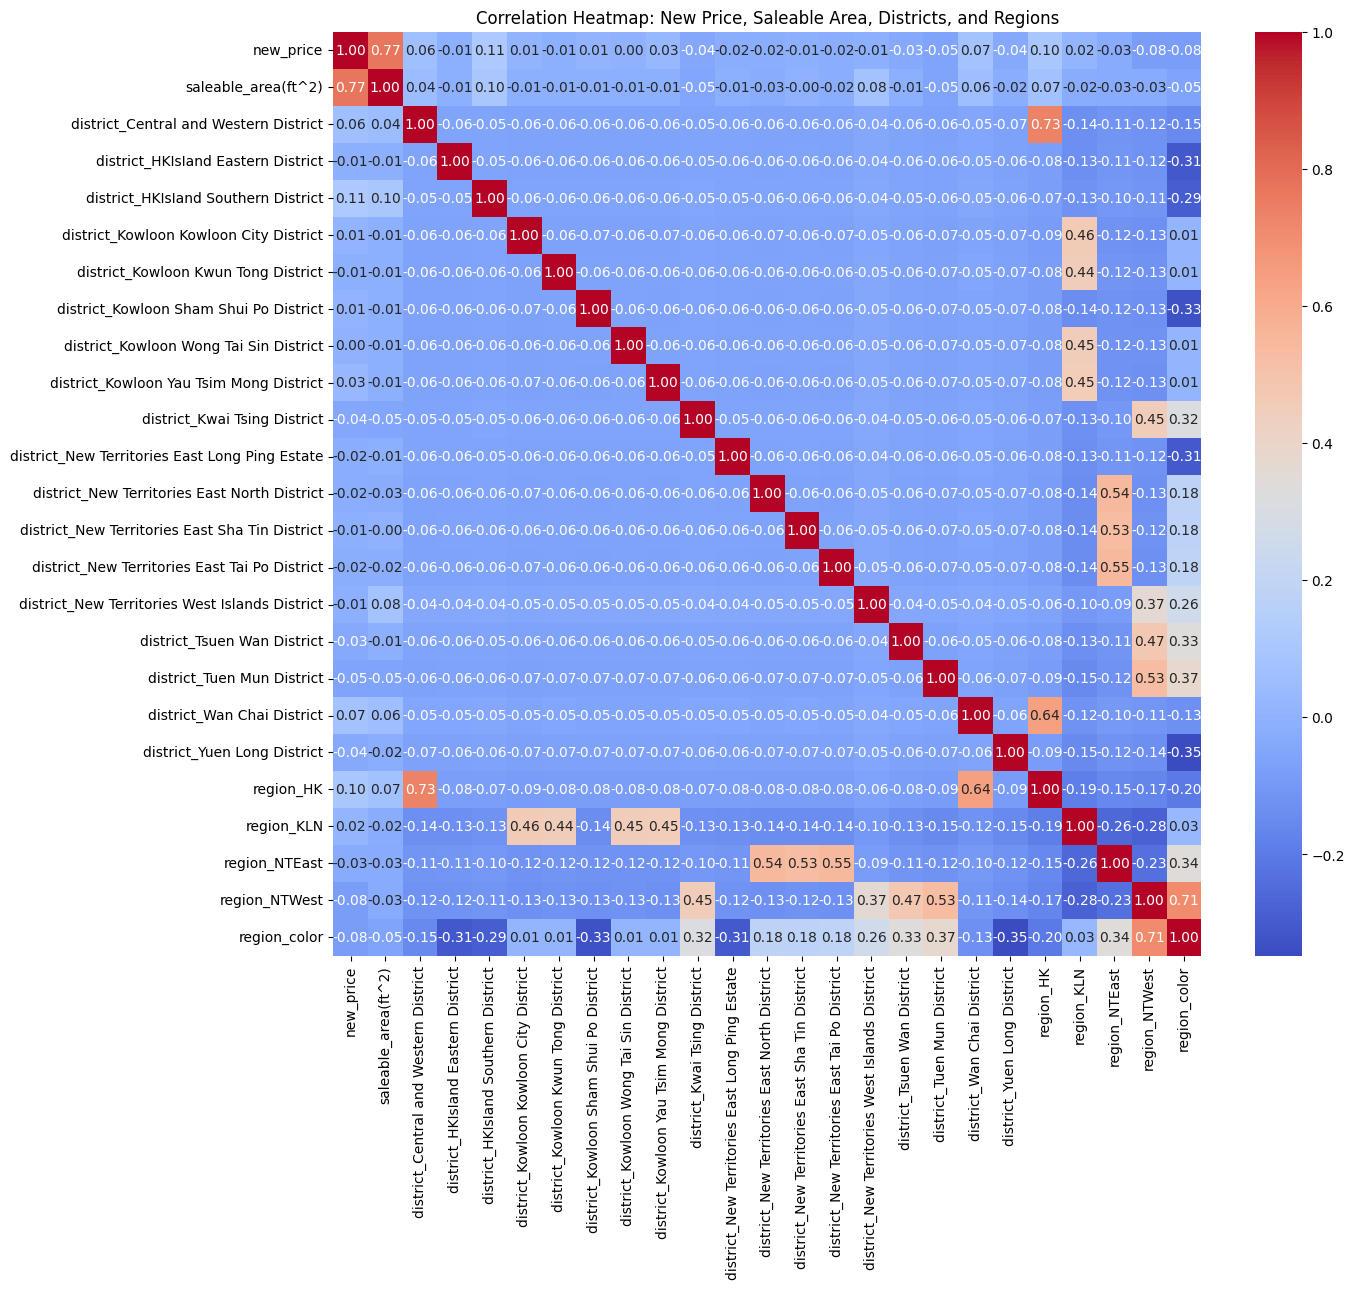

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select columns of interest
columns_of_interest = ['new_price', 'saleable_area(ft^2)'] + \
    [col for col in merged_dataset.columns if col.startswith('district_')] + \
    [col for col in merged_dataset.columns if col.startswith('region_')]

# Subset the DataFrame
correlation_data = merged_dataset[columns_of_interest]

# Ensure only numeric columns are included
numeric_correlation_data = correlation_data.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_correlation_data.corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot a heatmap for better visualization
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Heatmap: New Price, Saleable Area, Districts, and Regions')
plt.show()

Null values in numeric columns:
 saleable_area(ft^2)                               0
unit_rate                                         0
floor                                             0
CG                                                0
CI                                                0
CPI                                               0
GDP                                               0
HS                                                0
IR                                                0
LTV                                               0
M3                                                0
MW                                                0
PG                                                0
PI                                                0
SD                                                0
SM                                                0
SOLD                                              0
UR                                                0
district_Central and Western Di

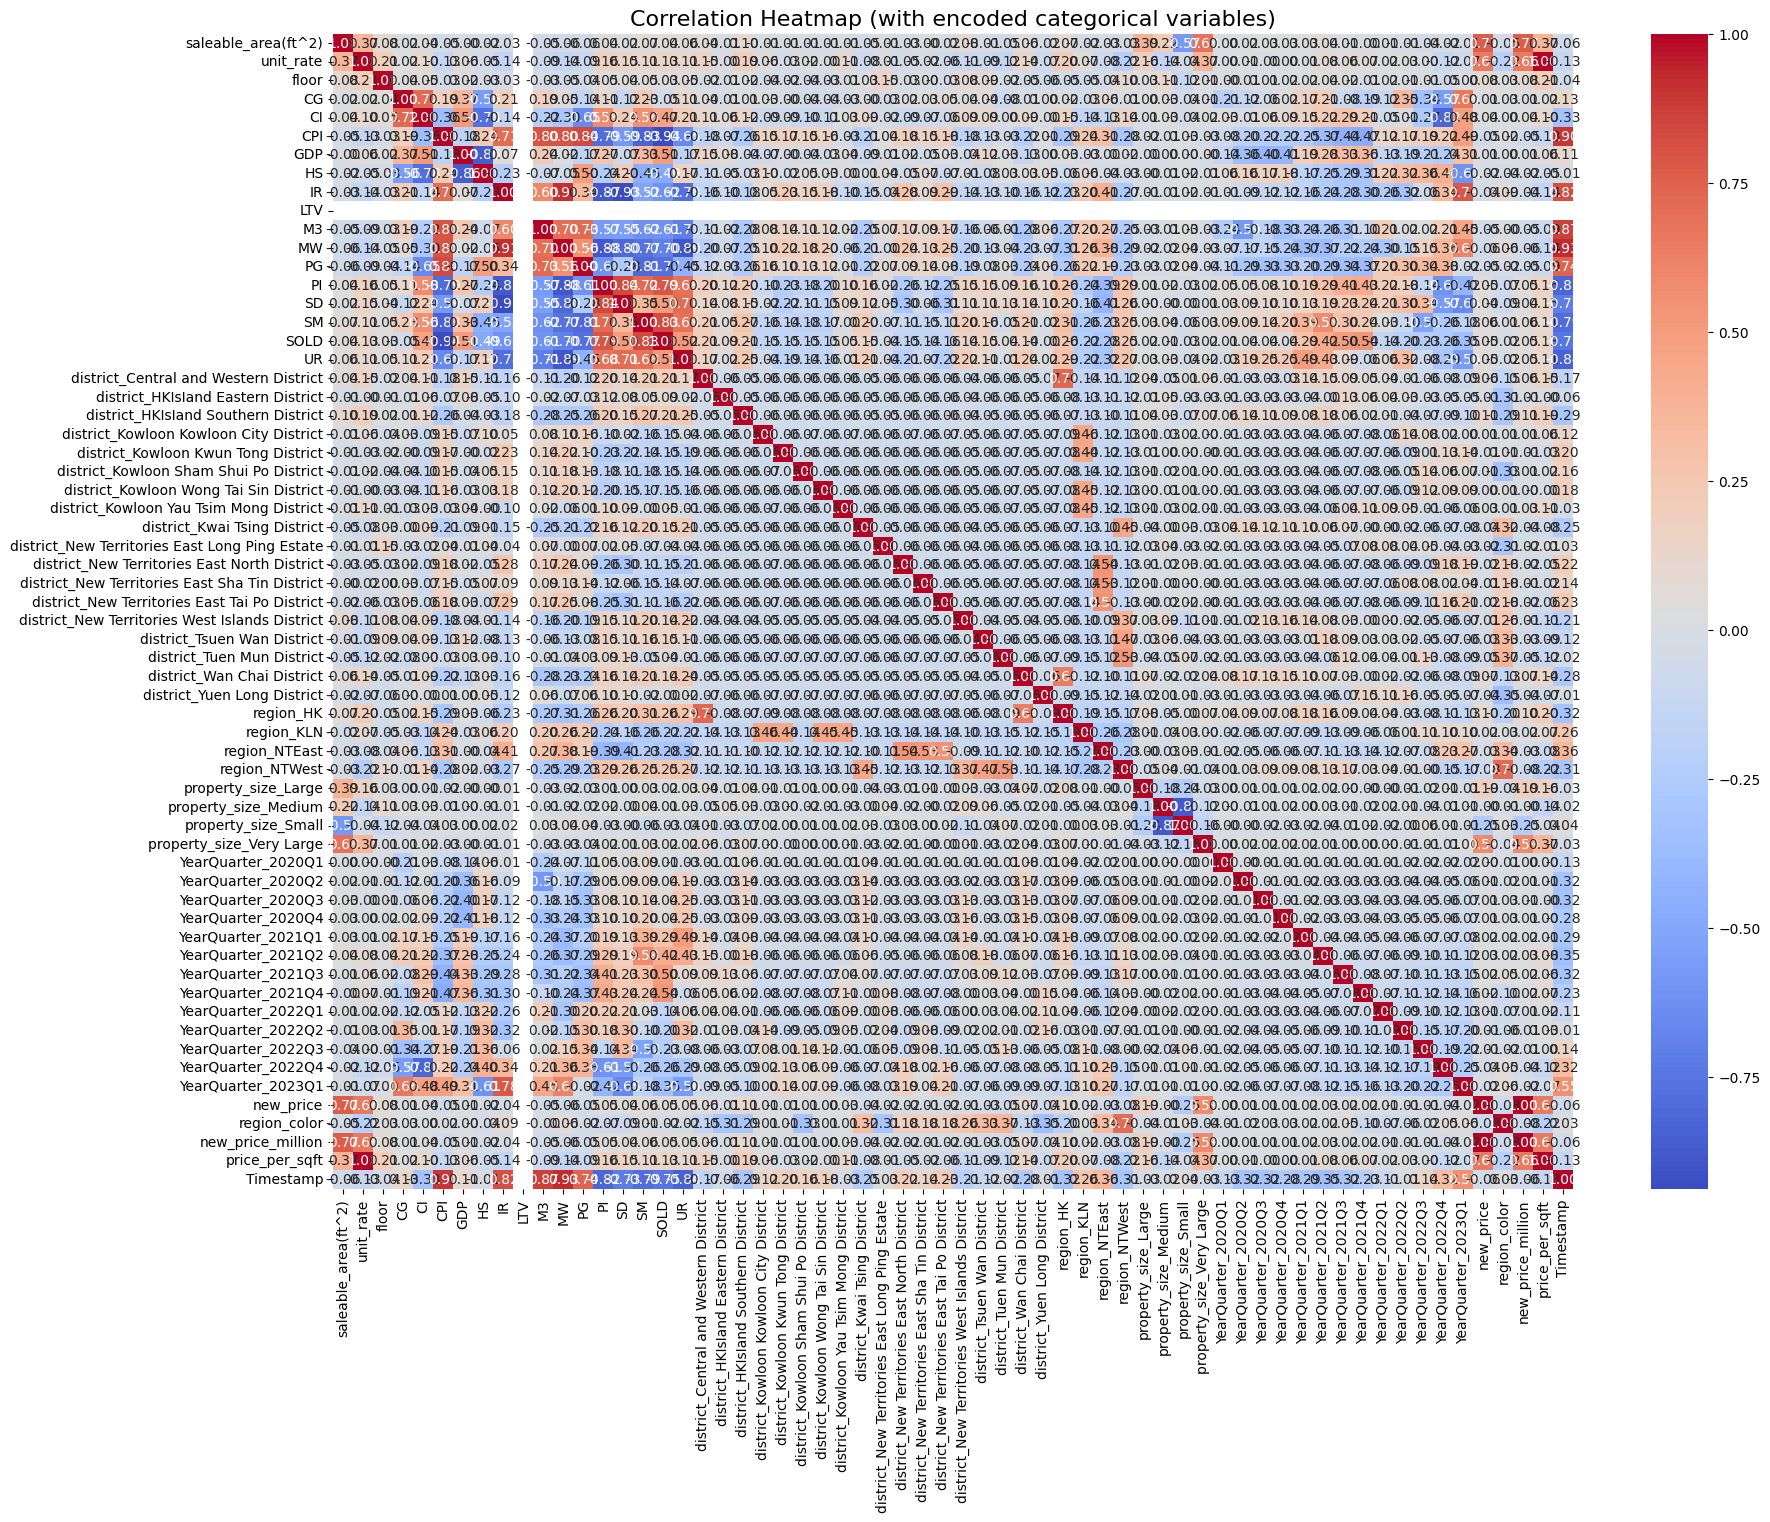

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Select only numeric columns
numeric_columns = merged_dataset.select_dtypes(include=[np.number])

# Step 2: Check for nulls in numeric data and drop rows with nulls, if any
print("Null values in numeric columns:\n", numeric_columns.isnull().sum())
numeric_columns = numeric_columns.dropna()

# Step 3: Compute the correlation matrix
correlation_matrix = numeric_columns.corr()

# Step 4: Plot the heatmap
plt.figure(figsize=(20, 15))  # Adjust the figure size for readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

# Customize the plot
plt.title('Correlation Heatmap (with encoded categorical variables)', fontsize=16)
plt.show()

# MISSING DATA ANALYSIS BY DISTRICT AND YEAR

In [ ]:
merged_dataset.groupby(['district', 'YearQuarter']).agg(
    Sales_Count=('new_price', 'count'),  # Count of sales
    Total_Price=('new_price', 'sum')     # Sum of prices
)

Sales_Count  Total_Price
district                              YearQuarter                          
Central and Western District          2021Q1               709  10472286482
                                      2021Q2              1121  17764144784
                                      2021Q3              1031  14750050402
                                      2021Q4               845  13143213031
                                      2022Q1               583   8572720216
                                      2022Q2               617   8490694245
                                      2022Q3               394   4516209689
                                      2022Q4               349   5739859883
                                      2023Q1               435   5555763537
HKIsIand Eastern District             2021Q2               292   2833690834
                                      2021Q3              1209  11405982456
                                      2021Q4               862   7891662740
                                      2022Q1               599   5848804806
                                      2022Q2               949   8583771215
                                      2022Q3               561   5213000987
                                      2022Q4               541   4463866909
                                      2023Q1               805   6605275212
HKIsIand Southern District            2020Q1                64    925014605
                                      2020Q2               407   6302471882
                                      2020Q3               391   6337542154
                                      2020Q4               337   5365854405
                                      2021Q1               418   8498733698
                                      2021Q2              1208  24722882910
                                      2021Q3               751  15050925337
                                      2021Q4               528  13881529488
                                      2022Q1               347   6361068909
                                      2022Q2               305   4383014595
                                      2022Q3               189   5011304742
                                      2022Q4               146   2472381956
                                      2023Q1               204   3181751885
Kowloon Kowloon City District         2022Q2              2051  21776631872
                                      2022Q3              1789  19859948341
                                      2022Q4              1448  13274724028
                                      2023Q1              1550  18863218324
Kowloon Kwun Tong District            2022Q3              1026   9017953106
                                      2022Q4              2442  21322792439
                                      2023Q1              2988  29308174155
Kowloon Sham Shui Po District         2022Q2               336   3576805979
                                      2022Q3              2249  23909326288
                                      2022Q4              1828  17505747652
                                      2023Q1              2192  24344622812
Kowloon Wong Tai Sin District         2022Q3              2021  21118161822
                                      2022Q4              2043  18815901146
                                      2023Q1              2422  25879006077
Kowloon Yau Tsim Mong District        2021Q3               766  11855568245
                                      2021Q4              1341  20554137063
                                      2022Q1               944  11461956031
                                      2022Q2              1176  11774300441
                                      2022Q3               886  10581601205
                                      2022Q4               610   6114100958
                                      2023Q1               859   8466560167
Kwai Tsing District    

In [ ]:
# Look at the sales in each quarter to see what is missing

# Group by district and YearQuarter, calculating number of sales and average price
summary = merged_dataset.groupby(['district', 'YearQuarter']).agg(
    Sales_Count=('new_price', 'count'),  # Count of sales
    Total_Price=('new_price', 'sum')     # Sum of prices
).reset_index()

# Calculate Average Price per YearQuarter
summary['Average_Price'] = summary['Total_Price'] / summary['Sales_Count']

# Convert Average_Price to HK$ million
summary['Average_Price'] = summary['Average_Price'] / 1000000

# Create a complete list of all districts and YearQuarters
all_districts = summary['district'].unique()
all_yearquarters = summary['YearQuarter'].unique()

# Create a full grid of all combinations
full_index = pd.MultiIndex.from_product([all_districts, all_yearquarters], names=['district', 'YearQuarter'])
full_summary = pd.DataFrame(index=full_index).reset_index()

# Merge with the summary to fill in "no data" where applicable
final_table = pd.merge(full_summary, summary, on=['district', 'YearQuarter'], how='left')

# Fill NaN values with "no data"
final_table['Sales_Count'].fillna("no data", inplace=True)
final_table['Average_Price'].fillna("no data", inplace=True)
final_table['Total_Price'].fillna("no data", inplace=True)
# Sort by YearQuarter and district
final_table.sort_values(by=['YearQuarter', 'district'], inplace=True)

# Set display option to show all rows
pd.set_option('display.max_rows', None)

# Display the full summary table
#print(final_table[['district', 'YearQuarter', 'Average_Price', 'Sales_Count']])
final_table.head(20)

,district,YearQuarter,Sales_Count,Total_Price,Average_Price
9,Central and Western District,2020Q1,no data,no data,no data
22,HKIsIand Eastern District,2020Q1,no data,no data,no data
35,HKIsIand Southern District,2020Q1,64.0,925014605.0,14.453353
48,Kowloon Kowloon City District,2020Q1,no data,no data,no data
61,Kowloon Kwun Tong District,2020Q1,no data,no data,no data
74,Kowloon Sham Shui Po District,2020Q1,no data,no data,no data
87,Kowloon Wong Tai Sin District,2020Q1,no data,no data,no data
100,Kowloon Yau Tsim Mong District,2020Q1,no data,no data,no data
113,Kwai Tsing District,2020Q1,50.0,289081798.0,5.781636
126,New Territories East Long Ping Estate,2020Q1,no data,no data,no data


In [ ]:
# Using a heatmanp to display the missing data

# First, replace "no data" with NaN for easier manipulation
final_table['Sales_Count'] = final_table['Sales_Count'].replace("no data", pd.NA)

# Create a matrix to show where data is missing
missing_data_matrix = final_table.pivot(index='district', columns='YearQuarter', values='Sales_Count')

# Convert the missing data to a binary format: 1 for data present, 0 for missing
missing_data_matrix = missing_data_matrix.notna().astype(int)  # 1 for data present, 0 for data missing
missing_data_matrix.head(20)


YearQuarter,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1
district,,,,,,,,,,,,,
Central and Western District,0,0,0,0,1,1,1,1,1,1,1,1,1
HKIsIand Eastern District,0,0,0,0,0,1,1,1,1,1,1,1,1
HKIsIand Southern District,1,1,1,1,1,1,1,1,1,1,1,1,1
Kowloon Kowloon City District,0,0,0,0,0,0,0,0,0,1,1,1,1
Kowloon Kwun Tong District,0,0,0,0,0,0,0,0,0,0,1,1,1
Kowloon Sham Shui Po District,0,0,0,0,0,0,0,0,0,1,1,1,1
Kowloon Wong Tai Sin District,0,0,0,0,0,0,0,0,0,0,1,1,1
Kowloon Yau Tsim Mong District,0,0,0,0,0,0,1,1,1,1,1,1,1
Kwai Tsing District,1,1,1,1,1,1,1,1,1,1,1,1,1


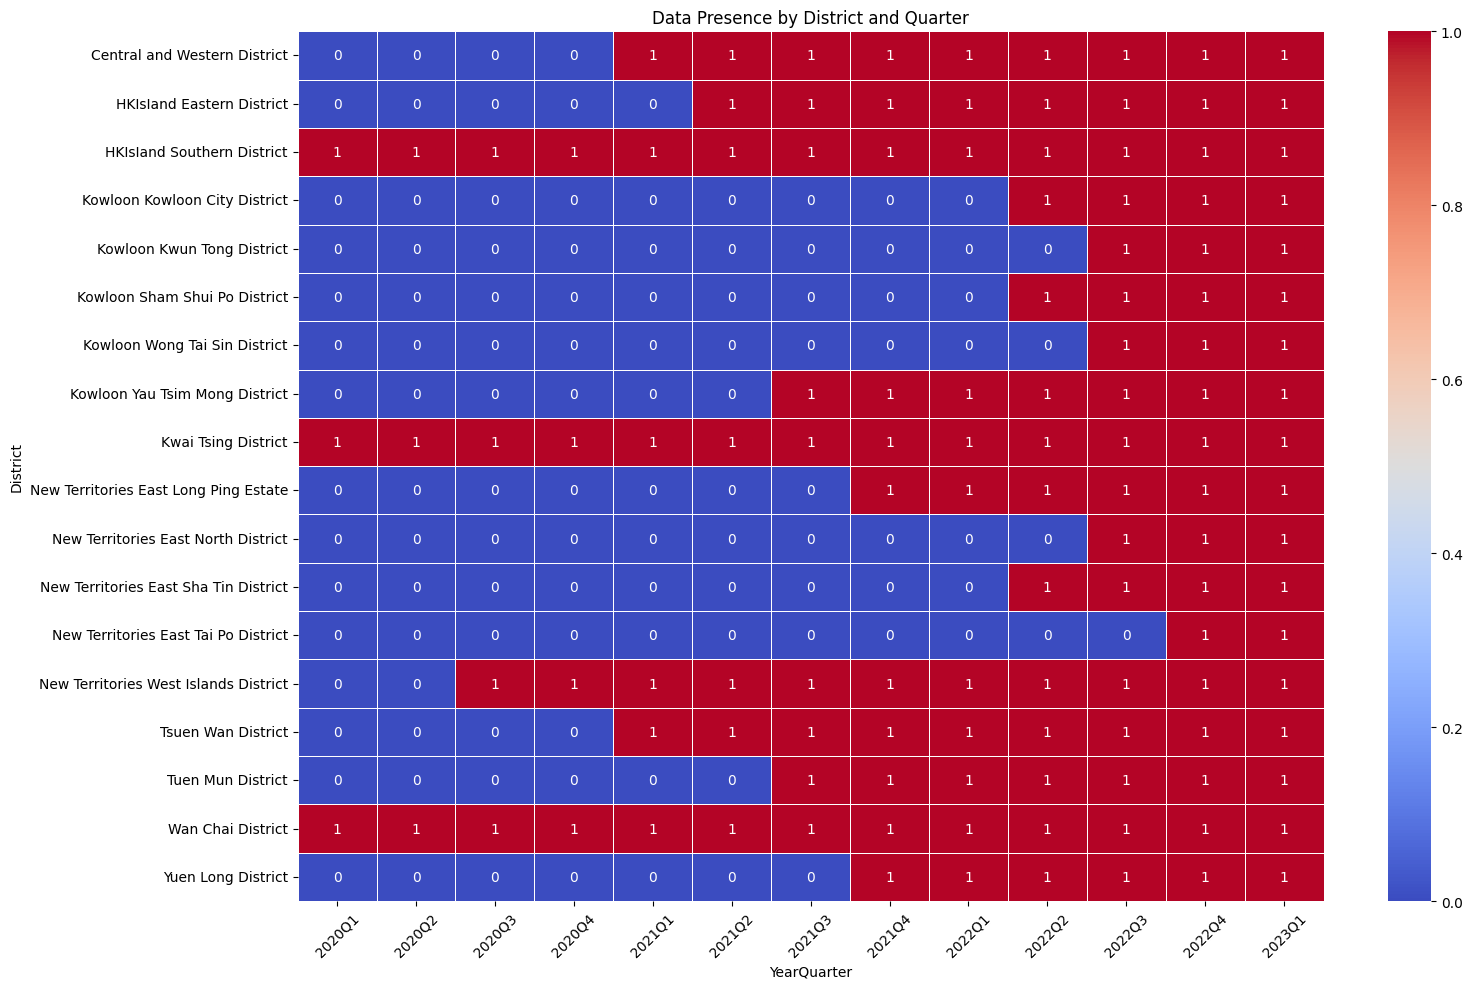

In [ ]:
# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(missing_data_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=.5)
plt.title('Data Presence by District and Quarter')
plt.xlabel('YearQuarter')
plt.ylabel('District')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Missing data clear by looing the average price for each district from 2020-2023

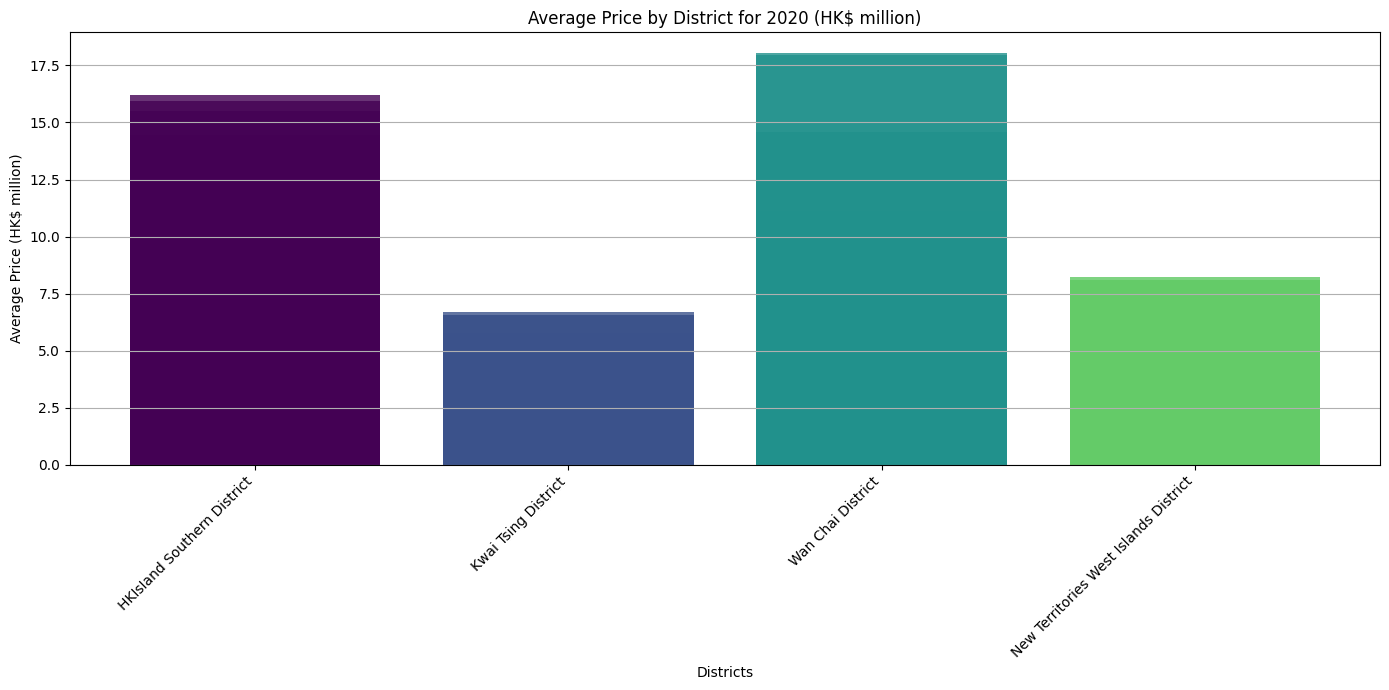

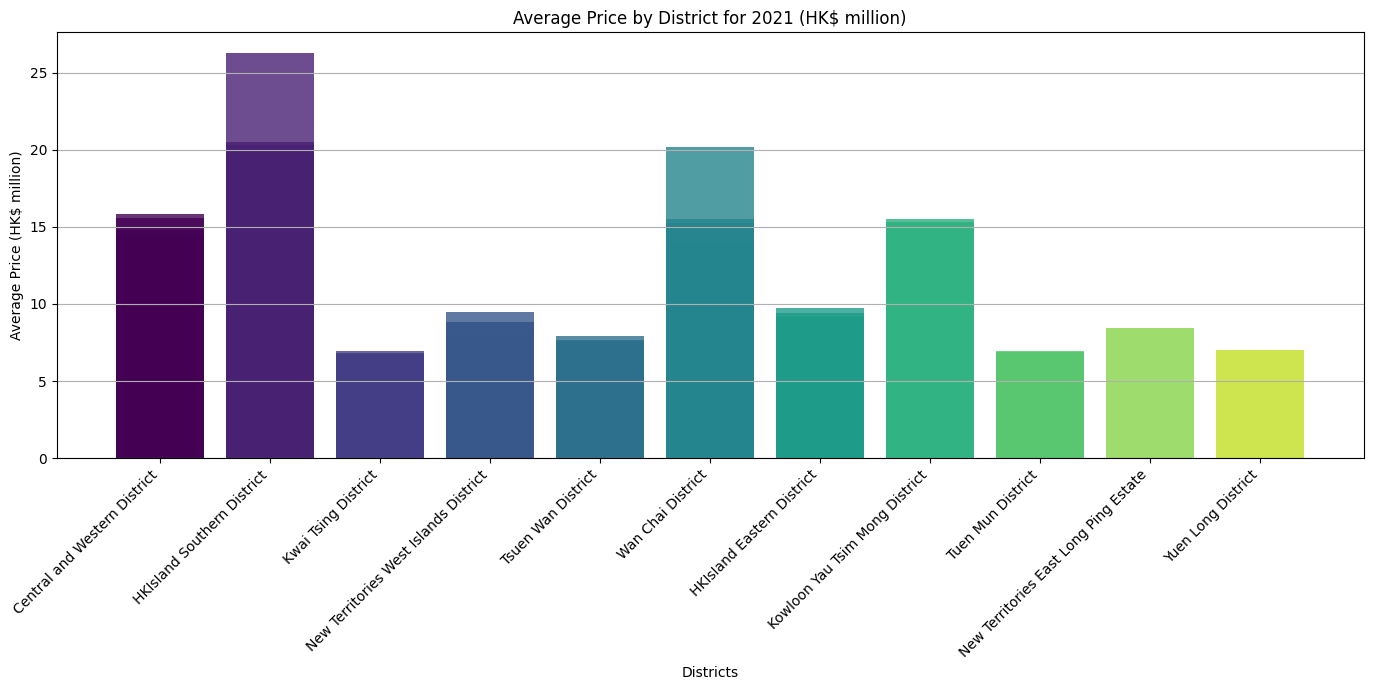

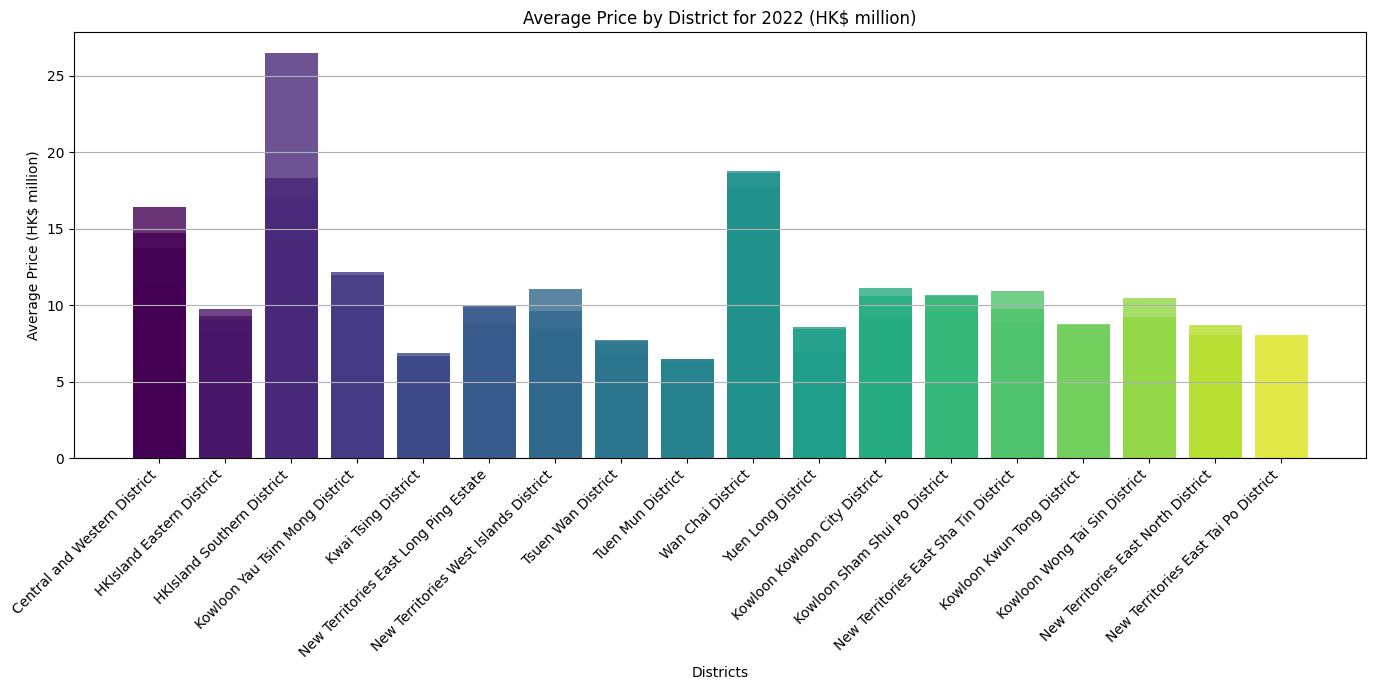

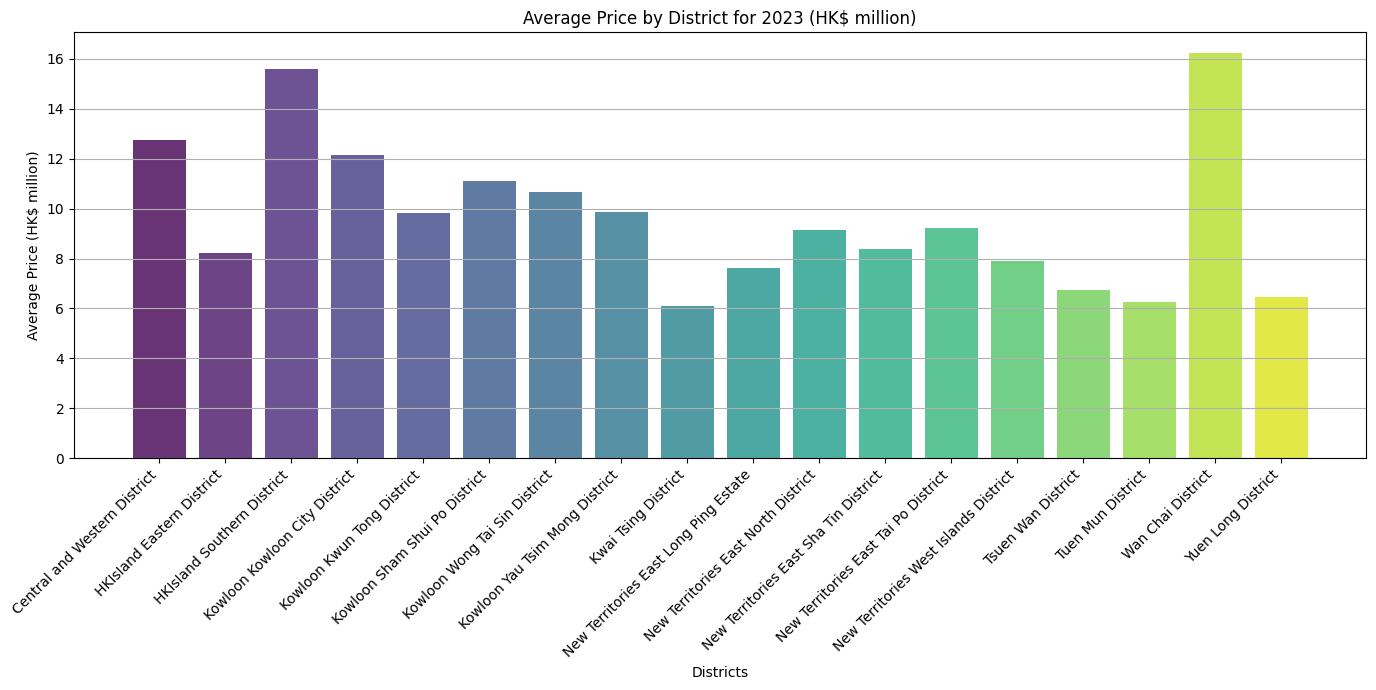

In [ ]:
# Filter out rows where Average Price is "no data"
plot_data = final_table[final_table['Average_Price'] != "no data"].copy()

# Convert Average_Price to float for plotting
plot_data['Average_Price'] = plot_data['Average_Price'].astype(float)

# Extract Year from YearQuarter as string for plotting
plot_data['Year'] = plot_data['YearQuarter'].astype(str).str[:4]  # Get the first 4 characters for the year

# Create a plot for each year
years = plot_data['Year'].unique()

# Use a colormap for unique colors
color_map = plt.cm.viridis

for year in years:
    plt.figure(figsize=(14, 7))

    # Filter data for the current year
    year_data = plot_data[plot_data['Year'] == year]

    # Assign unique colors to each district
    colors = [color_map(i / len(year_data['district'].unique())) for i in range(len(year_data['district'].unique()))]
    district_color_map = {district: colors[i] for i, district in enumerate(year_data['district'].unique())}

    # Plotting with unique colors
    plt.bar(year_data['district'], year_data['Average_Price'],
            color=[district_color_map[district] for district in year_data['district']], alpha=0.8)

    # Adding labels and title
    plt.title(f'Average Price by District for {year} (HK$ million)')
    plt.xlabel('Districts')
    plt.ylabel('Average Price (HK$ million)')
    plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
    plt.grid(axis='y')

    # Show the plot for the current year
    plt.tight_layout()
    plt.show()

# Optionally, display the summary table
#print(plot_data[['district', 'YearQuarter', 'Average_Price', 'Sales_Count']])

# PRICE DISTRIBUTION

In [ ]:
# Display the first 5 rows of the merged_dataset
print(merged_dataset.head(5))

   saleable_area(ft^2)  unit_rate                       district  floor  \
0                  423      15792  Kowloon Kowloon City District   22.0   
1                 2190      34703  Kowloon Kowloon City District    7.0   
2                  761      15857  Kowloon Kowloon City District   12.0   
3                  320      13717  Kowloon Kowloon City District   12.0   
4                  519      16541  Kowloon Kowloon City District   29.0   

  FormattedDate YearQuarter   CG    CI  CPI   GDP      HS    IR  LTV    M3  \
0    2023-03-08      2023Q1  9.1  66.1  2.0  91.4  5250.0  4.75  0.5  16.5   
1    2023-03-08      2023Q1  9.1  66.1  2.0  91.4  5250.0  4.75  0.5  16.5   
2    2023-03-08      2023Q1  9.1  66.1  2.0  91.4  5250.0  4.75  0.5  16.5   
3    2023-03-08      2023Q1  9.1  66.1  2.0  91.4  5250.0  4.75  0.5  16.5   
4    2023-03-08      2023Q1  9.1  66.1  2.0  91.4  5250.0  4.75  0.5  16.5   

     MW   PG     PI    SD     SM     SOLD   UR region  \
0  17.7  8.0 -10.24  0.

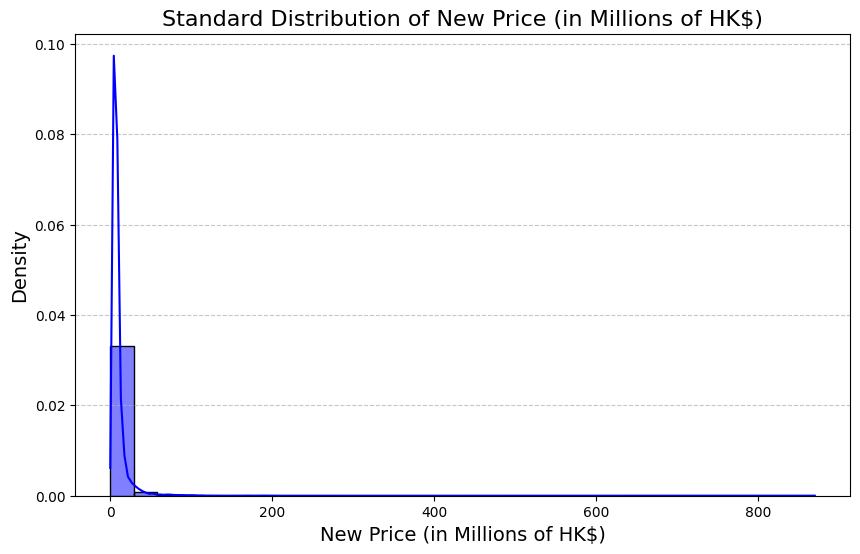

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_dataset is already loaded as a Pandas DataFrame
# Example: merged_dataset = pd.read_csv('path_to_your_dataset.csv')

# Check if the column 'new_price' exists
if 'new_price' not in merged_dataset.columns:
    raise ValueError("The column 'new_price' does not exist in the merged_dataset.")

# Scale the new_price column to millions of HK$
merged_dataset['new_price_millions'] = merged_dataset['new_price'] / 1_000_000

# Plot the standard distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged_dataset['new_price_millions'], kde=True, bins=30, color='blue', stat="density")
plt.title('Standard Distribution of New Price (in Millions of HK$)', fontsize=16)
plt.xlabel('New Price (in Millions of HK$)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

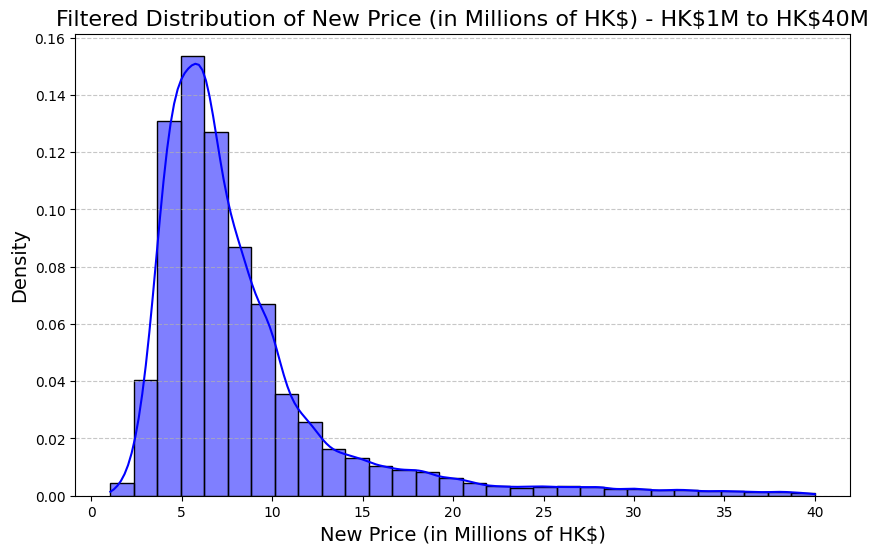

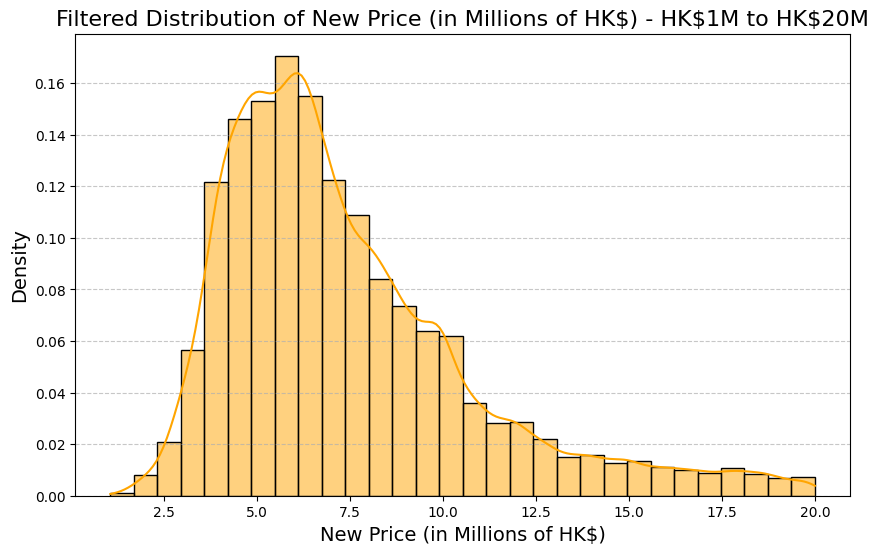

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_dataset is already loaded as a Pandas DataFrame
# Example: merged_dataset = pd.read_csv('path_to_your_dataset.csv')

# Check if the column 'new_price' exists
if 'new_price' not in merged_dataset.columns:
    raise ValueError("The column 'new_price' does not exist in the merged_dataset.")

# Filter dataset for new_price between 1,000,000 and 40,000,000
filtered_dataset140 = merged_dataset[(merged_dataset['new_price'] <= 40_000_000) &
                                      (merged_dataset['new_price'] >= 1_000_000)]

# Filter dataset for new_price between 1,000,000 and 20,000,000
filtered_dataset120 = merged_dataset[(merged_dataset['new_price'] <= 20_000_000) &
                                      (merged_dataset['new_price'] >= 1_000_000)]

# Save both datasets to CSV for future use
filtered_dataset140.to_csv('filtered_dataset140.csv', index=False)
filtered_dataset120.to_csv('filtered_dataset120.csv', index=False)

# Convert new_price to millions for plotting in both datasets
filtered_dataset140['new_price_millions'] = filtered_dataset140['new_price'] / 1_000_000
filtered_dataset120['new_price_millions'] = filtered_dataset120['new_price'] / 1_000_000

# Plot the distribution for filtered_dataset140
plt.figure(figsize=(10, 6))
sns.histplot(filtered_dataset140['new_price_millions'], kde=True, bins=30, color='blue', stat="density")
plt.title('Filtered Distribution of New Price (in Millions of HK$) - HK$1M to HK$40M', fontsize=16)
plt.xlabel('New Price (in Millions of HK$)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot the distribution for filtered_dataset120
plt.figure(figsize=(10, 6))
sns.histplot(filtered_dataset120['new_price_millions'], kde=True, bins=30, color='orange', stat="density")
plt.title('Filtered Distribution of New Price (in Millions of HK$) - HK$1M to HK$20M', fontsize=16)
plt.xlabel('New Price (in Millions of HK$)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
merged_dataset.shape

(109851, 69)

In [ ]:
filtered_dataset120.shape

(102229, 69)

In [ ]:
filtered_dataset140.shape

(107501, 69)

In [ ]:
# Display only object (string) columns in merged_dataset
object_columns = merged_dataset.select_dtypes(include=['object'])

# Display the information about object columns
print(object_columns.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109851 entries, 0 to 109850
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   district       109851 non-null  object
 1   YearQuarter    109851 non-null  object
 2   region         78917 non-null   object
 3   property_size  109851 non-null  object
 4   region_cat     78917 non-null   object
dtypes: object(5)
memory usage: 4.2+ MB
None


In [ ]:
import pandas as pd

# Display the initial shape of the dataset
print("Initial dataset shape:", merged_dataset.shape)

# Identify and drop all object (string) columns
object_columns = merged_dataset.select_dtypes(include=['object']).columns
print(f"Identified object columns to drop: {list(object_columns)}")

# Drop the object columns from the dataset
merged_dataset = merged_dataset.drop(columns=object_columns)

# Display the updated dataset information
print("Updated dataset shape:", merged_dataset.shape)
print("Remaining columns:")
print(merged_dataset.info())

Initial dataset shape: (109851, 69)
Identified object columns to drop: ['district', 'YearQuarter', 'region', 'property_size', 'region_cat']
Updated dataset shape: (109851, 64)
Remaining columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109851 entries, 0 to 109850
Data columns (total 64 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   saleable_area(ft^2)                             109851 non-null  int64         
 1   unit_rate                                       109851 non-null  int64         
 2   floor                                           109851 non-null  float64       
 3   FormattedDate                                   109851 non-null  datetime64[ns]
 4   CG                                              109851 non-null  float64       
 5   CI                                              109851 non-null  float64       
 6   CPI      

## Save the Dataframe

In [ ]:
# Save the merged dataset to a new CSV file
merged_dataset.to_csv('Merged_Datasetv4.csv', index=False)

In [ ]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Define the file path
file_path = '/content/drive/My Drive/Colab Notebooks/M5 Code and Data/Merged_Datasetv4.csv'

# Save the file
merged_dataset.to_csv(file_path, index=False)

# Verify if the file exists
if os.path.exists(file_path):
    print(f"File 'Merged_Datasetv4.csv' has been saved successfully!")
    print(f"Full file path: {file_path}")
else:
    print(f"File 'Merged_Datasetv4.csv' was not found in the directory!")

# Optionally unmount and remount Google Drive
drive.flush_and_unmount()
print("Drive unmounted. Please refresh Google Drive and remount if necessary.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File 'Merged_Datasetv4.csv' has been saved successfully!
Full file path: /content/drive/My Drive/Colab Notebooks/M5 Code and Data/Merged_Datasetv4.csv
Drive unmounted. Please refresh Google Drive and remount if necessary.


In [ ]:
# Save the filtered_dataset120 to a new CSV file
filtered_dataset120.to_csv('filtered_dataset120.csv', index=False)

In [ ]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Define the file path
file_path = '/content/drive/My Drive/Colab Notebooks/M5 Code and Data/filtered_dataset120.csv'

# Save the file
filtered_dataset120.to_csv(file_path, index=False)

# Verify if the file exists
if os.path.exists(file_path):
    print(f"File '/content/filtered_dataset120.csv' has been saved successfully!")
    print(f"Full file path: {file_path}")
else:
    print(f"File '/content/filtered_dataset120.csv' was not found in the directory!")

# Optionally unmount and remount Google Drive
drive.flush_and_unmount()
print("Drive unmounted. Please refresh Google Drive and remount if necessary.")

Mounted at /content/drive
File '/content/filtered_dataset120.csv' has been saved successfully!
Full file path: /content/drive/My Drive/Colab Notebooks/M5 Code and Data/filtered_dataset120.csv
Drive unmounted. Please refresh Google Drive and remount if necessary.
